In [1]:
import pandas as pd
from os.path import join, basename
from glob import glob
from scipy.stats import spearmanr
import numpy as np
from sklearn.metrics import mean_absolute_error
''''
hyperformer all
'''
PATIENT_GROUP_LOCATION_IN_FILENAME = -3
SUBKLINISCHE_GRUPPE = "Subklinische_Gruppe"
GROUP_BY_DATE = True
GROUP_SEPARATOR = "/"
ID_LOCATION_IN_FILENAME = -2
''''
    meta data and neutral texts 
'''
RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/"
BASELINE_FOLDER = "new_hyperformer++_base"
RESULT_FOLDER = "hyperformer++_ema_depression_tests_embeddings_nt"
''''
hyperformer all
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt"


''''
hyperformer reapprasials
'''
# PATIENT_GROUP_LOCATION_IN_FILENAME = -4
# SUBKLINISCHE_GRUPPE = "SubklinischeGruppe"
''''
    meta data 
'''
# RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
# BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/gpu1/"
# BASELINE_FOLDER = "hyperformer++_reapprasial"
# RESULT_FOLDER = "hyperformer++_reapprasial_meta_depression"
''''
hyperformer reapprasials
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_nt"
''''
hyperformer reapprasials
    meta data and neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_nt_many_hot"



"'\nhyperformer reapprasials\n    meta data and neutral texts \n"

In [2]:
def load_predictions(experiment, patient_groups=None, result_base_adjusted=None):
    predictions = {}
    if result_base_adjusted is None: 
        current_result_base = RESULTS_BASE 
    else: 
        current_result_base = result_base_adjusted
    fold_dirs = glob(f"{current_result_base}/{experiment}/*/")
    for fold_dir in fold_dirs:
        try:
            fold = int(fold_dir.split("/")[-2])
            fold_predictions = list(glob(f"{fold_dir}/*.csv"))[0]
            _predictions = parse_filename(pd.read_csv(fold_predictions))
            if patient_groups is not None:
                _predictions = _predictions[_predictions["patientGroup"].isin(patient_groups)]
            if not "true" in _predictions.columns:
                _predictions["true"] = _predictions[TRUE]
            predictions[fold] = _predictions
        except ValueError:
            print(f"{fold_dir} probably not a fold directory.")
    all_predictions = pd.concat(predictions.values())
    return predictions, all_predictions

def parse_filename(df):    
    

    # df["patientGroup"] = df["filename"].apply(lambda x: x.split("/")[-3])
    # df["ID"] = df["filename"].apply(lambda x: x.split("/")[-2])

    if GROUP_BY_DATE:
      
        df["date"] = df["filename"].apply(lambda x: "_".join(basename(x).split("_")[:-2]))

        df["Content"] = df["filename"].apply(
            lambda x: "_".join(basename(x).split("_")[-2:])
        )
        df["Content"] = df["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke")
    df["patientGroup"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[PATIENT_GROUP_LOCATION_IN_FILENAME])

    df["patientGroup"] = df["patientGroup"].apply(lambda x: SUBKLINISCHE_GRUPPE if x in SUBKLINISCHE_GRUPPE else x)

    df["ID"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[ID_LOCATION_IN_FILENAME])#PATIENT_GROUP_LOCATION_IN_FILENAME + 1
    return df
    
def session_mean(df):
    
    return df.groupby(["ID", "date", "patientGroup"])[["true", "prediction"]].mean().reset_index()
    

def compute_metrics(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
    return speaker_spearman, grouped_speaker_spearman


    
def compute_metrics_2(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    mae = mean_absolute_error(df["true"], df["prediction"])
    
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
        grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
        return speaker_spearman, grouped_speaker_spearman, mae, grouped_mae
    else:
        return speaker_spearman, mae


In [3]:
predictions, all_predictions = load_predictions(BASELINE_FOLDER, result_base_adjusted=BASELINE_BASE)
all_predictions.to_csv(BASELINE_FOLDER + "_predictions.csv", index=False)

/data/eihw-gpu2/pechleba/results//new_hyperformer++_base/runs/ probably not a fold directory.


In [4]:
def print_metrics(metrics):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f} ({np.std(metrics[key]):.3f})"
    return metric_string + " \\\\"

def print_metrics_2(metrics, metrics_mae):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f}\(\pm\){np.std(metrics[key]):.3f} & {np.mean(metrics_mae[key]):.3f}\(\pm\){np.std(metrics_mae[key]):.3f}"
    return metric_string + " \\\\"

def general_metrics(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho = compute_metrics(predictions_mean, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
    return metrics

def general_metrics_2(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    metrics_mae = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho, mae, grouped_mae = compute_metrics_2(predictions_mean, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        metrics_mae["All"].append(mae)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        for name, value in zip(grouped_mae.index, grouped_mae.values):
            metrics_mae[name].append(value)
    return metrics, metrics_mae

def phrase_metrics(experiment, result_base_adjusted):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"][content] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics

def type_metrics(experiment, folder=None):
    predictions_fold, predictions_all = load_predictions(experiment=experiment, result_base_adjusted=folder)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        predictions["Content"] = predictions["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke" if "positiverGedanke" in x else "Garbage")
        if GROUP_BY_DATE:
            numeric_columns = ["true", "prediction"] 
            predictions = predictions.groupby(["ID", "patientGroup", "Content", "date"])[numeric_columns].mean().reset_index()
            # predictions = predictions.groupby(["ID", "date", "patientGroup", "Content"]).mean().reset_index()
        else:
            predictions = predictions.groupby(["ID", "patientGroup", "Content"]).mean().reset_index()
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"][content] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics
    

In [5]:
m = phrase_metrics(RESULT_FOLDER, RESULTS_BASE)
print(pd.DataFrame(data=m).to_latex())

/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings_nt/runs/ probably not a fold directory.


/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.1

\begin{tabular}{lllll}
\toprule
{} &            All & Kontrollgruppe &   PatientInnen & Subklinische\_Gruppe \\
\midrule
Antwort          &  0.214 (0.044) &  0.165 (0.045) &  0.214 (0.090) &       0.249 (0.059) \\
Frage            &  0.135 (0.044) &  0.100 (0.041) &  0.153 (0.095) &       0.144 (0.067) \\
positiverGedanke &  0.123 (0.032) &  0.093 (0.011) &  0.119 (0.084) &       0.142 (0.020) \\
\bottomrule
\end{tabular}



/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_1783959/3478838223.py:2: Futu

In [22]:
m = phrase_metrics(RESULT_FOLDER)
print(pd.DataFrame(data=m).to_latex())

ValueError: No objects to concatenate

In [23]:
predictions = list(glob(join(RESULTS_BASE, RESULT_FOLDER, "**/*.csv")))
predictions_df = pd.concat([pd.read_csv(csv) for csv in predictions])
predictions_df.to_csv("predictions_"+RESULT_FOLDER+"_hyperformer.csv", index=False)

ValueError: No objects to concatenate

/data/eihw-gpu2/pechleba/results//new_hyperformer++_base/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_ema_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings_nt/runs/ probably not a fold directory.
      Unnamed: 0                                           filename  \
0              0  /data/eihw-gpu2/pechleba/ParaSpeChaD/EMA/Kontr...   
1              1  /data/eihw-gpu2/pechleba/ParaSpeChaD/EMA/Kontr...   
2              2  /data/eihw-gpu2/pechleba/ParaSpeChaD/EMA/Kontr...   
3              3  /data/eihw-gpu2/pechleba/ParaSpeChaD/EMA/Kontr...   
4              4  /data/eihw-gpu2/pechleba/ParaSpeChaD/EMA/Kontr...   
...          ...                                                ...   
9750        9750  /data/eihw-gpu2/pechleba/ParaSpeChaD/EMA/Kontr...   
9

/tmp/ipykernel_1553596/3871028697.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


embed
_____________________________
0.20379755645350017 0.23991627006224478
0.24145180140260608 0.24438134145542476
Mean diff: 0.037654244949105804 (0.1603962788790701)
______________________________
tests\&embed
_____________________________
0.20379755645350017 0.23991627006224478
0.23813650359101943 0.2244400373517268
Mean diff: 0.03433894713751915 (0.12673905479697156)
______________________________
tests\&embed\&nt
_____________________________
0.19879818762665796 0.2407031039900603
0.23628092562848924 0.2332718610589488
Mean diff: 0.03748273800183121 (0.16474610215985092)
______________________________
138
nan nan


/tmp/ipykernel_1553596/3871028697.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/tmp/ipykernel_1553596/3871028697.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWa

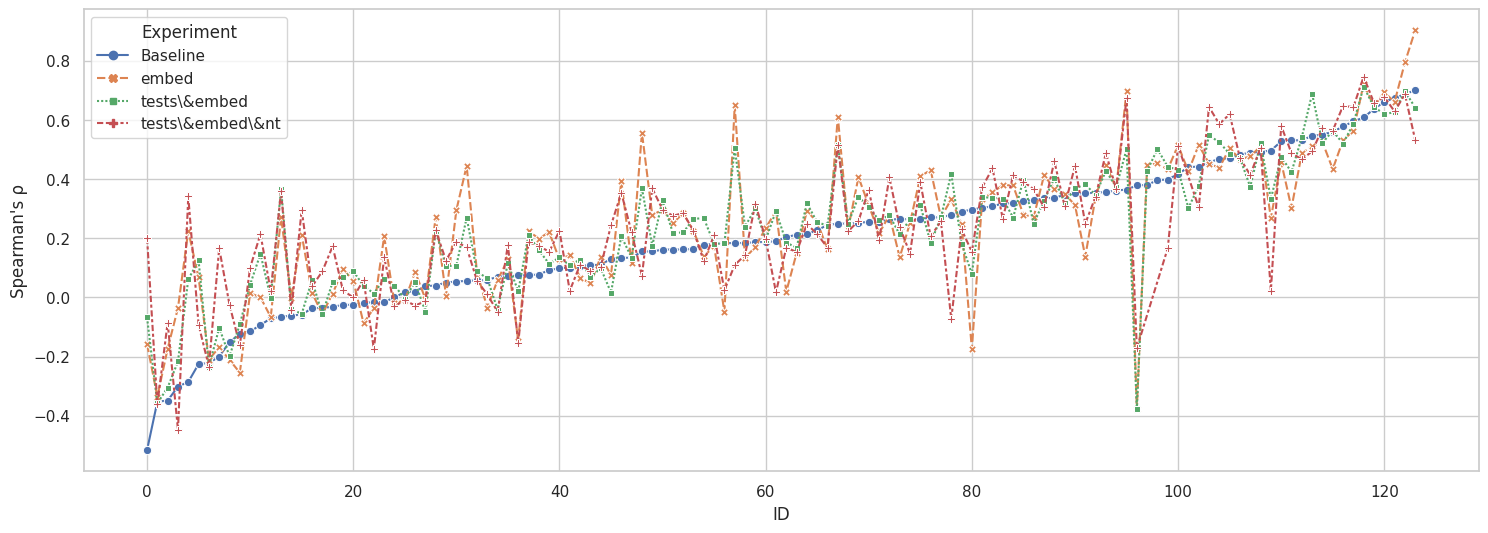

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]
configs = [
    
    
    ("Baseline", "new_hyperformer++_base", "/data/eihw-gpu2/pechleba/results/"),
    #("tests", "hyperformer++_ema_depression_tests", "/data/eihw-gpu2/pechleba/results/"),
    ("embed", "hyperformer++_ema_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    #("nt", "hyperformer++_ema_nt", "/data/eihw-gpu2/pechleba/results/"),
    ("tests\&embed", "hyperformer++_ema_depression_tests_embeddings", "/data/eihw-gpu2/pechleba/results/"),
    #("tests\&nt", "hyperformer++_ema_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/"),
    ("tests\&embed\&nt", "hyperformer++_ema_depression_tests_embeddings_nt", "/data/eihw-gpu2/pechleba/results/"),
    
]

predictions_list = []
for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    # if "Hyperformer" in name:
    #     name = "Hyperformer"
    predictions["Experiment"] = name
    predictions_list.append(predictions)

predictions = pd.concat(predictions_list)

predictions = predictions[predictions.patientGroup.isin(groups)]
print(predictions)
if GROUP_BY_DATE:
    predictions = (
        predictions.groupby(["ID", "Experiment", "date", "patientGroup"])
        .mean()
        .reset_index()
    )

predictions = (
    predictions[["ID", "Experiment", "prediction", "true"]]
    .groupby(["ID", "Experiment"])
    .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
    .sort_values()
    .sort_index(level="Experiment", sort_remaining=False)
    .reset_index()
)

    
predictions_for_avg = predictions

predictions_for_avg.columns = ["ID", "Experiment", "Spearman's ρ"]
nan_rows = predictions_for_avg[predictions_for_avg["Spearman's ρ"].isna()]

predictions_for_avg = predictions_for_avg[~predictions_for_avg.index.isin(nan_rows.index)]

ids_in_embedding_meta = predictions[predictions['Experiment'] == 'Hyperformer EMA Embedding Meta']['ID'].unique()
ids_in_meta_nt = predictions[predictions['Experiment'] == 'Baseline']['ID'].unique()
#ids_not_in_meta_nt = set(ids_in_meta_nt) -set(ids_in_embedding_meta)

predictions_baseline_avg = predictions_for_avg[
    predictions_for_avg.Experiment == "Baseline"].sort_values(
    by="ID"
)

for name, path, result_base_adjusted in configs:
    if name != "Baseline":
        print(name)
        print("_____________________________")
        predictions_hyperformer_avg = predictions_for_avg[
            predictions.Experiment == name
        ].sort_values(by="ID")
        common_indices = predictions_baseline_avg.index[predictions_baseline_avg["ID"].isin(predictions_hyperformer_avg["ID"])]
        predictions_baseline_avg = predictions_baseline_avg.loc[common_indices]
        print(np.mean(predictions_baseline_avg["Spearman\'s ρ"].values), np.std(predictions_baseline_avg["Spearman\'s ρ"].values))
        print(np.mean(predictions_hyperformer_avg["Spearman\'s ρ"].values), np.std(predictions_hyperformer_avg["Spearman\'s ρ"].values))

        help = predictions_baseline_avg["Spearman's ρ"].values

        predictions_baseline_avg["Diff"] = (
            predictions_hyperformer_avg["Spearman's ρ"].values
            - help
        )

        print(
            f"Mean diff: {predictions_baseline_avg['Diff'].mean()} ({np.std(predictions_baseline_avg['Diff'])})"
        )
        print("______________________________")

# print((predictions["ID"].values))
print(len(set(predictions["ID"].values)))
predictions["ID"] = pd.factorize(predictions["ID"].values, sort=False)[0]

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ Base"
].sort_values(by="ID")

predictions.columns = ["ID", "Experiment", "Spearman's ρ"]
predictions_baseline = predictions[predictions.Experiment == "Baseline"].sort_values(
    by="ID"
)

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ adapter"
].sort_values(by="ID")



predictions_hyperformer.sort_values(by="Spearman's ρ").to_csv("name.csv", index=False)
sns.set_theme(style="whitegrid", rc={"figure.figsize": (18, 6)})
sns.lineplot(
    data=predictions,
    x="ID",
    y="Spearman's ρ",
    hue="Experiment",
    style="Experiment",
    markers=True,
)
predictions_hyperformer.columns = ["ID", "Experiment", "Spearman's ρ"]

nan_rows = predictions_hyperformer[predictions_hyperformer["Spearman's ρ"].isna()]

predictions_hyperformer = predictions_hyperformer[~predictions_hyperformer.index.isin(nan_rows.index)]

print(np.mean(predictions_hyperformer["Spearman\'s ρ"].values), np.std(predictions_hyperformer["Spearman\'s ρ"].values))


plt.savefig(f"speaker_performance_{RESULT_FOLDER.split('/')[-1]}_{'_'.join(groups)}.pdf")


In [53]:
table_contents = []
for name, path, result_base_adjusted in configs:
    m, mae = general_metrics_2(path, result_base_adjusted=result_base_adjusted)

    table_contents.append(f"{name} {print_metrics_2(m, mae)}")
print("\n".join(table_contents))


/data/eihw-gpu2/pechleba/results//new_hyperformer++_base/runs/ probably not a fold directory.


/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.1

/data/eihw-gpu2/pechleba/results//hyperformer++_ema_embeddings/runs/ probably not a fold directory.


/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.1

/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings/runs/ probably not a fold directory.


/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.1

/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings_nt/runs/ probably not a fold directory.


/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/pechleba/miniconda/.venv/lib/python3.1

Baseline  & 0.204\(\pm\)0.050 & 1.699\(\pm\)0.215 & 0.114\(\pm\)0.034 & 0.803\(\pm\)0.171 & 0.217\(\pm\)0.104 & 3.026\(\pm\)0.516 & 0.248\(\pm\)0.062 & 1.174\(\pm\)0.087 \\
embed  & 0.241\(\pm\)0.052 & 1.850\(\pm\)0.259 & 0.174\(\pm\)0.058 & 1.064\(\pm\)0.086 & 0.268\(\pm\)0.071 & 2.954\(\pm\)0.383 & 0.261\(\pm\)0.070 & 1.361\(\pm\)0.289 \\
tests\&embed  & 0.238\(\pm\)0.060 & 1.378\(\pm\)0.274 & 0.162\(\pm\)0.061 & 0.642\(\pm\)0.312 & 0.252\(\pm\)0.097 & 2.431\(\pm\)0.333 & 0.272\(\pm\)0.062 & 1.048\(\pm\)0.143 \\
tests\&embed\&nt  & 0.237\(\pm\)0.057 & 1.504\(\pm\)0.243 & 0.179\(\pm\)0.034 & 0.756\(\pm\)0.156 & 0.230\(\pm\)0.140 & 2.522\(\pm\)0.151 & 0.280\(\pm\)0.074 & 1.254\(\pm\)0.333 \\


In [54]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

NameError: name 'long_df' is not defined

In [55]:
import pyreadstat
#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/fixed_merged_file.csv")

long_dfs = []
wide_df = df.copy()

# configs = [
#     ("Baseline", BASELINE_FOLDER, BASELINE_BASE),
#     ("Hyperformer Reapprasial NT META", RESULT_FOLDER, RESULTS_BASE),
#     ("Hyperformer Reapprasial META", "hyperformer++_reapprasial_meta", BASELINE_BASE),
#    # ("Hyperformer PHQ-9", "hyperformer++_phq9"),
#    # ("Hyperformer HAMD", "hyperformer++_hamd"),
#    # ("Hyperformer BDI", "hyperformer++_bdi"),
#    # ("Hyperformer Depression Tests", "hyperformer++_depression_tests"),
#    # ("Hyperformer Demographics+Medication", "hyperformer++_demographics_medication"),
#    # ("Hyperformer SEK", "hyperformer++_sek"),
#    # ("Hyperformer Personality", "hyperformer++_personality"),
# ]
for name, path, result_base_adjusted in configs:
    _, predictions_hyperformer = load_predictions(path, result_base_adjusted=result_base_adjusted)

    predictions_hyperformer = (
        predictions_hyperformer.groupby(["ID", "date", "patientGroup"])
        .mean()
        .reset_index()
    )
    predictions_hyperformer = (
        predictions_hyperformer[["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .dropna()
        .reset_index()
    )
    predictions_hyperformer_long = predictions_hyperformer.copy()
    predictions_hyperformer_long["Experiment"] = name
    long_dfs.append(predictions_hyperformer_long)
    predictions_hyperformer[name] = predictions_hyperformer[0]
    wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")
long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")
long_df["Spearman"] = long_df[0]

/data/eihw-gpu2/pechleba/results//new_hyperformer++_base/runs/ probably not a fold directory.


/tmp/ipykernel_1553596/2726184820.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


/data/eihw-gpu2/pechleba/results//hyperformer++_ema_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_1553596/2726184820.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_1553596/2726184820.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


/data/eihw-gpu2/pechleba/results//hyperformer++_ema_depression_tests_embeddings_nt/runs/ probably not a fold directory.


/tmp/ipykernel_1553596/2726184820.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_1553596/2726184820.py:39: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ID_y', '0_y'} in the result is deprecated and will raise a MergeError in a future version.
  wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")


In [56]:
correlations = wide_df.corr(method="spearman")

/tmp/ipykernel_1553596/2743425926.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = wide_df.corr(method="spearman")


In [ ]:
long_df

,ID,0,Experiment,Code,group,t1_datum,t1_state_01,t1_state_02,t1_state_03,t1_state_04,...,f4_median,nsyll,npause,dur(s),phonationtime(s),speechrate(nsyll / dur),articulation rate(nsyll / phonationtime),ASD(speakingtime / nsyll),subject,Spearman
0,AE0348,0.207447,Baseline,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.900,101.9580,4.180791,5.080523,0.196830,AE0348,0.207447
1,AE0348,0.183010,Hyperformer All,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.900,101.9580,4.180791,5.080523,0.196830,AE0348,0.183010
2,AH0761,0.241218,Baseline,AH0761,1.0,2022-03-22,0.0,NaN,0.0,NaN,...,3606.805109,587,38,147.525,116.3840,3.978987,5.043649,0.198269,AH0761,0.241218
3,AH0761,0.298158,Hyperformer All,AH0761,1.0,2022-03-22,0.0,NaN,0.0,NaN,...,3606.805109,587,38,147.525,116.3840,3.978987,5.043649,0.198269,AH0761,0.298158
4,AJ1149,0.265301,Baseline,AJ1149,0.0,2022-02-10,0.0,NaN,0.0,NaN,...,3887.929165,525,25,132.175,104.5760,3.972007,5.020272,0.199192,AJ1149,0.265301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,VA0967,0.273072,Hyperformer All,VA0967,1.0,2021-06-01,0.0,NaN,0.0,NaN,...,3803.955303,679,37,176.225,146.4320,3.853029,4.636965,0.215658,VA0967,0.273072
244,VS0276,0.055495,Baseline,VS0276,1.0,2021-11-26,0.0,NaN,0.0,NaN,...,3822.734649,543,32,144.275,120.3375,3.763646,4.512309,0.221616,VS0276,0.055495
245,VS0276,0.037336,Hyperformer All,VS0276,1.0,2021-11-26,0.0,NaN,0.0,NaN,...,3822.734649,543,32,144.275,120.3375,3.763646,4.512309,0.221616,VS0276,0.037336
246,WH1242,-0.036358,Baseline,WH1242,1.0,2022-03-23,0.0,NaN,1.0,"Venlafaxin, 150 mg (täglich, morgens)",...,3815.677420,523,34,125.000,104.2400,4.184000,5.017268,0.199312,WH1242,-0.036358


In [59]:
phq9_columns = ['t1_phq_1', 't1_phq_2', 't1_phq_3', 't1_phq_4', 't1_phq_5', 't1_phq_6', 't1_phq_7', 't1_phq_8', 't1_phq_9', 't1_phq_sum']
hamd_columns = ['t1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't1_HAMD17_ges']
sek_columns = ['t1_sek_1', 't1_sek_2', 't1_sek_3', 't1_sek_4', 't1_sek_5', 't1_sek_6', 't1_sek_7', 't1_sek_8', 't1_sek_9', 't1_sek_10', 't1_sek_11', 't1_sek_12', 't1_sek_13', 't1_sek_14', 't1_sek_15', 't1_sek_16', 't1_sek_17', 't1_sek_18', 't1_sek_19', 't1_sek_20', 't1_sek_21', 't1_sek_22', 't1_sek_23', 't1_sek_24', 't1_sek_25', 't1_sek_26', 't1_sek_27']
sums = ["t1_sek_sum", "t1_phq_sum", "t1_HAMD17_ges", "group"]

In [62]:
print(correlations[sums].loc[[x[0] for x in configs]].to_latex())
# Compute correlation between sek and std of mood ratings

\begin{tabular}{lrrrr}
\toprule
{} &  t1\_sek\_sum &  t1\_phq\_sum &  t1\_HAMD17\_ges &     group \\
\midrule
Baseline         &   -0.190549 &    0.235741 &       0.172321 &  0.217482 \\
embed            &   -0.126048 &    0.151791 &       0.138453 &  0.153470 \\
tests\textbackslash \&embed     &   -0.126516 &    0.157989 &       0.123033 &  0.154342 \\
tests\textbackslash \&embed\textbackslash \&nt &   -0.044923 &    0.151300 &       0.103815 &  0.126280 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1553596/2292493842.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(correlations[sums].loc[[x[0] for x in configs]].to_latex())


In [ ]:
print(list(correlations.columns))

['0_x', 'Hyperformer All', '0_y', 'Baseline', 'group', 't1_state_01', 't1_state_03', 't1_state_05', 't1_state_07', 't1_state_08', 't1_state_09', 't1_state_10', 't1_state_11', 't1_state_12', 't1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't2_state_01', 't2_state_03', 't2_state_05', 't2_state_07', 't2_state_08', 't2_state_09', 't2_state_10', 't2_state_11', 't2_state_12', 't2_HAMD_01', 't2_HAMD_02', 't2_HAMD_03', 't2_HAMD_04', 't2_HAMD_05', 't2_HAMD_06', 't2_HAMD_07', 't2_HAMD_08', 't2_HAMD_09', 't2_HAMD_10', 't2_HAMD_11', 't2_HAMD_12', 't2_HAMD_13', 't2_HAMD_14', 't2_HAMD_15', 't2_HAMD_16', 't2_HAMD_17', 't2_HAMD_18', 't2_HAMD_19', 't2_HAMD_20', 't2_HAMD_21', 't2_HAMD_22', 't2_HAMD_23', 't2_HAMD_24', 'fu

In [ ]:
df["t1_HAMD24_ges"] = df[list(filter(lambda x: "t1_HAMD" in x, list(df.columns)))].apply(lambda x: sum(x), axis=1)

In [ ]:
df[["Code", "t1_HAMD17_ges"]].sort_values(by="t1_HAMD17_ges").to_csv("hamd17.csv", index=False)